# 长短期记忆网络LSTM&GRU（下）

**目录**

**1 长短期记忆网络LSTM**<br>

&emsp;&emsp; 1.1 权重冲突与LSTM的解决方案<br>
&emsp;&emsp; 1.2 LSTM的计算单元与基本结构<br>
&emsp;&emsp; 1.3 LSTM的计算流程与数学本质探讨<br>
&emsp;&emsp; 1.4 在PyTorch中实现LSTM<br>
&emsp;&emsp;&emsp;&emsp; 1.4.1 nn.LSTM的参数群<br>
&emsp;&emsp;&emsp;&emsp; 1.4.2 nn.LSTM的输入、输出与架构实现<br>

============以下内容在《长短期记忆网络LSTM&GRU （下）》==============

&emsp;&emsp; 1.5 实战：nn.LSTM的预测与挑战<br>
&emsp;&emsp;&emsp;&emsp; 1.5.1 单变量时间序列预测流程<br>
&emsp;&emsp;&emsp;&emsp; 1.5.2 多变量时序与面板数据的预测流程<br>
&emsp;&emsp;&emsp;&emsp; 1.5.3 单步预测、多步预测与递归预测法<br>
&emsp;&emsp;&emsp;&emsp; 1.5.4 LSTM在股价数据上的预测实战<br>
&emsp;&emsp; 1.6 深度：LSTM究竟如何解决梯度问题？<br>

**2 循环门控单元GRU**<br><br>

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/00.png)

长短期记忆网络（Long Short-Term Memory Network，简称LSTM）是一种特殊的循环神经网络，它于1997年被慕尼黑技术大学的两位神经网络研究者提出，是当代深度学习领域中对时序数据和文字数据都具有重要作用的核心架构之一。在NLP的世界中，RNN为神经网络赋予了“记忆”的能力，LSTM则实现了对这种“记忆”方式的改良和优化——在RNN的基础上，LSTM的研究者们从权重冲突问题出发，提出了恒定梯度回路（Constant Error Carousel，CEC）、记忆细胞、门控单元、内部状态漂移等关键概念，从数学原理、架构设计、应用效率等多个方面革新了循环神经网络，大幅提升了循环网络的效果与性能。经过复杂的数学改造和工程优化，LSTM可以轻松处理拥有数千个时间步的长序列、还能有效缓解RNN中严重的梯度动荡问题，给致力于稳定神经网络训练流程的学者们带来无穷启发。在诞生26年之后，LSTM的论文原文依然是梯度研究方向的金典之作，LSTM算法本身也逐渐发展成为深度学习序列数据领域的根基架构。

今天，尽管自然语言处理领域众多大型模型和更先进的Transformer架构已经占据主流，但面临时间序列问题时，LSTM依然是众多深度学习竞赛和企业应用场景中的首选算法；在许多实际应用场景当中，模块化的LSTM也能够与CNN、GAN等架构有机结合，有效地创造在某些场景下超越transformer算法的效率或性能；同时，在LSTM基础上改进而诞生的GRU等算法，也在时间序列应用场景中有一席之地。LSTM的崛起和其持久的影响无疑为整个循环网络系列在序列数据研究领域确立了不可撼动的地位。今天，让我们一起来探索这一卓越结构背后的奥秘。

## 1.5 实战：nn.LSTM的预测与挑战

### 1.5.1 跑通单变量时间序列预测流程

In [ ]:
import numpy as np #数据处理
import pandas as pd #数据处理
import matplotlib as mlp
import matplotlib.pyplot as plt #绘图
from sklearn.preprocessing import MinMaxScaler #·数据预处理
from sklearn.metrics import mean_squared_error
import torch 
import torch.nn as nn #导入pytorch中的基本类
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data

In [3]:
print(np.__version__)
print(pd.__version__)
print(mlp.__version__)
print(torch.__version__)

1.22.4
2.1.4
3.8.2
2.2.0+cu121


- **导入数据**

In [5]:
df = pd.read_csv(r'D:\pythonwork\2021DL\NLP\lstm\airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

In [6]:
df.head() #单变量时间序列数据无需对时间维度进行处理

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


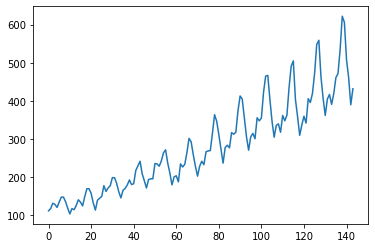

In [10]:
plt.plot(timeseries) #非常有规律的一个数据，对于LSTM来说相对容易
plt.show()

- **数据分割与滑窗**

In [35]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

> - 什么是滑窗？滑窗在机器学习/深度学习世界中的意义是什么？

滑动窗口技术涉及将连续的数据流划分为多个“窗口”，每个窗口包含一段时间序列的子集。在时间序列预测中，滑动窗口用于创建预测模型的训练样本。例如，如果我们想预测未来某个时间点的值，我们可以使用过去几个时间点的数据作为输入特征。在机器学习和深度学习的世界中，我们都常用滑窗的手段，针对不同的算法，滑窗手法带来的效果却截然不同。以下面的数据为例——

|时间|特征1|特征2|
|:-:|:-:|:-:|
|Date0|xxx|xxx|
|Date1|xxx|xxx|
|Date2|xxx|xxx|
|...|xxx|xxx|
|Daten|xxx|xxx|

在机器学习的世界中，滑窗带有“去时序化”的意味，这是因为机器学习算法（如lgbm，随机森林等等）是研究特征与标签之间关系的算法，机器学习算法群并不研究样本与样本之间的关联，而时间序列的内在逻辑是样本与样本之间的关联逻辑，因此在机器学习当中，我们利用滑窗“去时序化”后，将从上至下的时间序列关联滑窗为从左到右的特征与标签之间的关联。具体来看，在机器学习中，滑窗之后的数据往往呈现如下结构：

|时间|...|Date7前1天<br>特征1|Date7前2天<br>特征1|Date7前3天<br>特征1|...|Date7前1天<br>特征2|Date7前2天<br>特征2|Date7前3天<br>特征2|....|标签|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Date0|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|……|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date7|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date8|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date9|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|...|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date10|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|

但在深度学习、尤其是序列数据的世界中，我们的滑窗操作会生成的数据结构是：

> - **表单1**

|时间|特征1|特征2|
|:-:|:-:|:-:|
|**Date0**|xxx|xxx|
|**Date1**|xxx|xxx|
|**Date2**|xxx|xxx|
|...|xxx|xxx|
|**Date7**|xxx|xxx|
|**标签**|xxx|xxx|

> - **表单2**

|时间|特征1|特征2|
|:-:|:-:|:-:|
|**Date1**|xxx|xxx|
|**Date2**|xxx|xxx|
|**Date3**|xxx|xxx|
|...|xxx|xxx|
|**Date8**|xxx|xxx|
|**标签**|xxx|xxx|

> - **表单3**

|时间|特征1|特征2|
|:-:|:-:|:-:|
|**Date2**|xxx|xxx|
|**Date3**|xxx|xxx|
|**Date4**|xxx|xxx|
|...|xxx|xxx|
|**Date9**|xxx|xxx|
|**标签**|xxx|xxx|

这两种滑窗结构有明显的不同，其核心特点是“**时间维度的不同**”和“**能否打乱纵向的样本排列顺序**”，因两种不同的滑窗结构，这两种数据也适用于不同的机器学习和深度学习算法。

在本次单变量时间序列数据案例当中，我们采用的是第二种方法进行滑窗。在滑窗技巧中，有两个关键的因素非常重要，一个是“窗的大小”，另一个是“滑动的步长”。在大多数的时候我们只会考虑窗的大小，而一般不对步长进行修改。

In [45]:
#单变量时间序列滑窗函数

import torch
def create_dataset(dataset, lookback):
    """
    将时间序列转变为能够用于训练和预测的数据
    
    参数:
        dataset: ndarry，第一个维度是时间
        lookback: 滑窗的窗的大小
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        #target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(X), torch.FloatTensor(y)

> - 滑窗函数代码解析

In [46]:
#创建训练集与测试集
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([89, 7, 1]) torch.Size([89, 1])
torch.Size([41, 7, 1]) torch.Size([41, 1])


In [47]:
for x_, y_ in zip(X_train,y_train):
    print(x_,y_)
    break

y_train[0]

- **定义网络架构与训练元素**

In [67]:
#选择了最为简单的网络架构来进行实验
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        #现在我要的是最后一个时间步，而不是全部时间步了
        x = self.linear(x[:,-1,:])
        return x

In [68]:
#设置GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [69]:
#设置参数
input_size = 1  #输入特征的维度
hidden_size = 50 #LSTM隐藏状态的维度
num_layers = 1 #LSTM层的数量
output_size = 1 #模型的输出维度
n_epochs = 2000 #迭代epoch
learning_rate = 0.001 #学习率

In [70]:
#实例化模型
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate) #定义优化器
loss_fn = nn.MSELoss() #定义损失函数
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8) #将数据分批次

In [71]:
for x,y in loader:
    print(x.shape)
    print(y)
    break

torch.Size([8, 7, 1])
tensor([[234.],
        [355.],
        [259.],
        [193.],
        [293.],
        [163.],
        [243.],
        [302.]])


- **实际训练流程**

In [72]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #验证与打印
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device)).cpu()
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test.to(device)).cpu()
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 231.3658, test RMSE 428.8696
Epoch 100: train RMSE 186.5346, test RMSE 382.1577
Epoch 200: train RMSE 152.2639, test RMSE 345.3699
Epoch 300: train RMSE 122.5366, test RMSE 311.7413
Epoch 400: train RMSE 98.6056, test RMSE 281.7494
Epoch 500: train RMSE 71.8821, test RMSE 244.2719
Epoch 600: train RMSE 54.0116, test RMSE 213.5541
Epoch 700: train RMSE 42.0944, test RMSE 194.0356
Epoch 800: train RMSE 34.5988, test RMSE 174.8605
Epoch 900: train RMSE 29.7907, test RMSE 170.5281
Epoch 1000: train RMSE 26.6360, test RMSE 141.6537
Epoch 1100: train RMSE 23.8831, test RMSE 132.5804
Epoch 1200: train RMSE 23.5865, test RMSE 121.6976
Epoch 1300: train RMSE 19.9781, test RMSE 118.3079
Epoch 1400: train RMSE 18.7755, test RMSE 112.8421
Epoch 1500: train RMSE 17.3526, test RMSE 107.7514
Epoch 1600: train RMSE 15.9780, test RMSE 100.3437
Epoch 1700: train RMSE 14.3680, test RMSE 97.0989
Epoch 1800: train RMSE 13.2114, test RMSE 94.9483
Epoch 1900: train RMSE 12.3218, test RMSE

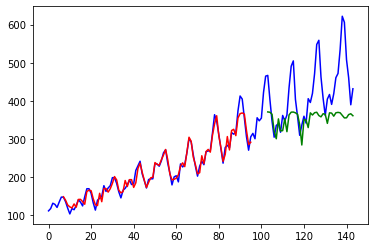

In [78]:
with torch.no_grad():
    # 绘制训练集上的损失的图像
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train.to(device)).cpu()
    train_plot[lookback:train_size] = model(X_train.to(device)).cpu()
    # 绘制测试集上的损失的图像
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test.to(device)).cpu()
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

- **从序列到点的预测转变为序列到序列的预测**

序列到序列（Seq2Seq）预测和序列到点（Seq2Point）预测在处理时间序列数据时各有优势。特别是对于LSTM这样的循环神经网络，这两种方法都可以被有效地利用。让我们来比较一下它们各自的优势：

> 序列到序列（Seq2Seq）预测

捕获长期依赖关系：Seq2Seq模型特别适合于那些需要理解整个输入序列来生成整个输出序列的任务。LSTM的优势在于能够捕获长期的时间依赖性，这使得它在Seq2Seq预测中非常有效。

连续输出预测：当需要连续预测多个未来时间点时，Seq2Seq模型可以一次性提供整个输出序列，这对于需要连续决策或规划的应用非常有用。

灵活性和泛化能力：Seq2Seq模型可以被训练来处理不同长度的输入和输出序列，提供更高的灵活性和泛化能力。

多功能性：Seq2Seq模型不仅限于时间序列预测，还可以用于其他任务，如机器翻译、文本摘要等。

> 序列到点（Seq2Point）预测

简单性和高效性：Seq2Point模型通常比Seq2Seq模型更简单，易于实现和训练。这种方法在计算上更高效，因为它仅预测单个输出值。

准确性：在某些情况下，Seq2Point模型可能比Seq2Seq模型提供更准确的单点预测，因为它专注于预测一个特定的未来时刻，而不是整个序列。

降低过拟合风险：由于模型结构较为简单，Seq2Point模型可能较少受到过拟合的影响，尤其是在数据量较少的情况下。

适用性：Seq2Point预测非常适用于那些只需预测一个未来时刻的任务，例如短期负载预测或股价预测。

选择Seq2Seq还是Seq2Point模型取决于具体的应用需求。如果任务涉及到对未来一系列时间点的连续预测，Seq2Seq模型是更好的选择。然而，如果任务只需要预测一个特定的未来时刻，Seq2Point模型可能更为合适，因为它更简单、更高效，并且可能更准确。在实际应用中，考虑数据的特性、预测的需求和可用资源是非常重要的。

In [79]:
import torch
def create_dataset(dataset, lookback):
    """
    序列到序列预测的滑窗函数
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(X), torch.FloatTensor(y)

In [80]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([89, 7, 1]) torch.Size([89, 7, 1])
torch.Size([41, 7, 1]) torch.Size([41, 7, 1])


In [85]:
for x_, y_ in zip(X_train,y_train):
    print(x_, "\n \n", y_)
    break

tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.],
        [135.],
        [148.]]) 
 
 tensor([[118.],
        [132.],
        [129.],
        [121.],
        [135.],
        [148.],
        [148.]])


In [86]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 7)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [87]:
#device = "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [88]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device)).cpu()
        train_rmse = np.sqrt(loss_fn(y_pred
                                     , y_train))
        y_pred = model(X_test.to(device)).cpu()
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 224.8474, test RMSE 423.6746
Epoch 100: train RMSE 175.4201, test RMSE 371.9661
Epoch 200: train RMSE 137.3603, test RMSE 330.4726
Epoch 300: train RMSE 106.9641, test RMSE 294.4650
Epoch 400: train RMSE 84.8498, test RMSE 263.3934
Epoch 500: train RMSE 63.0843, test RMSE 230.6918
Epoch 600: train RMSE 49.2545, test RMSE 203.6607
Epoch 700: train RMSE 39.5057, test RMSE 180.2176
Epoch 800: train RMSE 33.1067, test RMSE 160.2575
Epoch 900: train RMSE 28.1978, test RMSE 143.7549
Epoch 1000: train RMSE 24.8665, test RMSE 129.6951
Epoch 1100: train RMSE 22.2744, test RMSE 116.9509
Epoch 1200: train RMSE 20.2718, test RMSE 107.0073
Epoch 1300: train RMSE 19.2075, test RMSE 99.3532
Epoch 1400: train RMSE 20.5165, test RMSE 93.5716
Epoch 1500: train RMSE 18.2590, test RMSE 90.8696
Epoch 1600: train RMSE 17.6633, test RMSE 87.0046
Epoch 1700: train RMSE 17.3083, test RMSE 83.9677
Epoch 1800: train RMSE 16.9683, test RMSE 82.5182
Epoch 1900: train RMSE 16.9705, test RMSE 81.

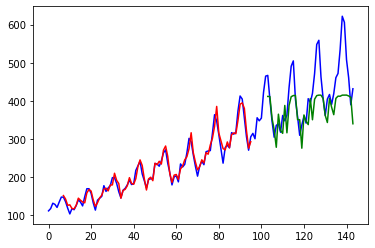

In [89]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train.to(device)).cpu()
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train.to(device)).cpu()[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test.to(device)).cpu()[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

### 1.5.2 多变量时序与面板数据的预测流程

#### 1.5.2.1 单变量、多变量与面板数据

在之前的课程中我们讲解了LSTM在单变量时间序列数据上预测的代码，这是一套最为基础、最为入门级的LSTM运行代码，我们借助它了解了滑窗这一重要操作以及时间序列预测中的多种概念，但这套代码却很难被用到深度学习领域中各种各样复杂的时间序列场景下。在深度学习的世界当中，单变量数据集往往比较少见，同时深度学习世界所面临的数据往往量大且复杂，因此一套单变量数据集的预测代码更多是帮助我们梳理使用LSTM时的实际预测流程，而非实际投入应用。今天我们将在我们原本理解的单变量数据预测的基础上继续拓展、以讲解多变量以及更复杂的数据集被应用于LSTM时我们应该做出的一系列处理。

首先在时间序列的世界中，除了最常见的单变量时间序列之外，我们还有多变量时间序列数据和面板数据两种复杂经典数据结构。我们在深度学习/机器学习以及无数的时间序列课程中都曾讲解过这几种数据的关键定义与区别。

> - **单变量时间序列**：只包含时间索引和唯一列的序列，在这样的序列中，时间与标签是一一绑定的，我们只需要知道时间即可确定唯一的标签。对于单变量数据集，我们需要预测的标签也就是数据集中唯一的列，这样的数据没有特征，是理解难度最小、但预测难度最大的时间序列数据类型。这种数据集中，日期往往是从上到下、从过去到未来地进行排列。由于日期能够确定唯一的标签，因此这种数据集中的日期一定不会重复。如果出现了重复的日期，则需要深入调查、或予以删除。

| 日期     | 平均温度<br>（标签） |
|---------|--------|
| Date0   | 22°C   |
| Date1   | 21°C   |
| Date2   | 23°C   |
| ...     | ...    |
| DateN   | 25°C   |

> - **多变量时间序列**：多变量时间序列数据的定义在过去的几年中发生了几次变化，在今天它大多数时间指代**一个时间点下拥有多个不同的特征**的时间序列数据。例如，我们想要预测一支股票在不同日期下的收盘价时，我们可以在一个日期下收集到多重的信息，比如开盘价、当日最高价、当日最底价、成交量、交易额等等，来构成如下的数据集——

| 日期     | 开盘价 | 最高价 | 最低价 | 收盘价<br>（标签）  | 交易量    | 成交额      |
|---------|------|------|------|------|--------|----------|
| Date0   | 100  | 105  | 99   | 103  | 500000 | 52000000 |
| Date1   | 103  | 108  | 102  | 107  | 600000 | 64200000 |
| Date2   | 107  | 109  | 106  | 108  | 550000 | 59400000 |
| ...     | ...  | ...  | ...  | ...  | ...    | ...      |
| DateN   | 110  | 115  | 109  | 114  | 620000 | 70680000 |

此时除了我们要预测的标签之外，我们还拥有更多帮助我们进行预测的信息，这是比单变量数据更加合理地情况。单变量数据和多变量数据之间的差异就在于特征数量的多少，如果我们给单变量时间序列加上特征，那单变量时间序列可以转变为多变量时间序列，比如——

| 日期     | 平均温度<br>（标签）  | 最高温度 | 最低温度 | 降水量 | 风速  | 湿度  |
|---------|--------|--------|--------|------|------|------|
| Date0   | 22°C   | 28°C   | 18°C   | 0mm  | 5km/h| 60%  |
| Date1   | 21°C   | 26°C   | 17°C   | 2mm  | 7km/h| 65%  |
| Date2   | 23°C   | 30°C   | 20°C   | 0mm  | 4km/h| 55%  |
| ...     | ...    | ...    | ...    | ...  | ...  | ...  |
| DateN   | 25°C   | 32°C   | 22°C   | 0mm  | 6km/h| 50%  |

与但变量时间序列相同，多变量时间序列数据中的日期往往是从上到下、从过去到未来地进行排列。由于日期能够确定唯一的标签，因此这种数据集中的日期一定不会重复。如果出现了重复的日期，则需要深入调查、或予以删除。

> - **面板数据（Pedal Data）**：面板数据是近年来兴起的一种特殊的数据类型名称，它用于描述除了时间之外、还有另外的索引辅助我们确定唯一标签的数据。例如，当我们要预测商品在某一特定日期下的销售额时，我们除了知道具体的日期之外，还需要知道商品ID；当我们要预测某一位用户在某一个日期下的行为时，除了需要知道具体的日期之外，我们还需要知道具体的用户ID；像这样**需要时间和至少另一个ID来共同决定唯一标签**的数据集，被称之为是面板数据。在过去，我们将这样的数据集称之为多变量时间序列，但现在“多变量时间序列”这一名字大多用于称呼拥有多个特征的时间序列，而像这样需要两个或以上的索引来决定唯一标签的数据有了新的名字面板数据。如下所示——

| 股票ID | 日期     | 开盘价 | 最高价 | 最低价 | 收盘价<br>（标签） | 交易量    | 成交额      |
|-------|---------|------|------|------|------|--------|----------|
| A     | Date0   | 100  | 105  | 99   | 103  | 500000 | 52000000 |
| A     | Date1   | 103  | 108  | 102  | 107  | 600000 | 64200000 |
| A     | Date2   | 107  | 109  | 106  | 108  | 550000 | 59400000 |
| ...   | ...     | ...  | ...  | ...  | ...  | ...    | ...      |
| A     | DateN   | 110  | 115  | 109  | 114  | 620000 | 70680000 |
| B     | Date0   | 200  | 210  | 198  | 205  | 400000 | 82000000 |
| B     | Date1   | 205  | 215  | 202  | 210  | 450000 | 94500000 |
| B     | Date2   | 210  | 220  | 210  | 218  | 500000 | 109000000|
| ...   | ...     | ...  | ...  | ...  | ...  | ...    | ...      |
| B     | DateN   | 250  | 260  | 248  | 255  | 550000 | 140250000|

在这个数据集中，我们需要预测的标签是股票的收盘价，但是除了日期之外，我们还需要先确认股票ID，才能确定特定股票在特定日期下的收盘价。你可以观察到，在每一支股票的ID下面，日期是从上至下、从过去到未来排列的，但是从整个数据集来看，跨越股票ID这一索引，我们却可以拥有重复的日期、并且日期并不是完全严格从上至下、从过去到未来排列的。在这样的数据中，我们称**时间为该数据的一个截面，股票ID为数据的另一个截面**，两个截面数据归拢在同一张表单中，构成了面板数据。

<font color="red">**在过去，面板数据一直被我们称之为多变量时间序列数据，这个曾经正确的称呼现在已被“面板数据”这一称呼替代，多变量时间序列数据的概念范围被压缩，现在仅仅指代具有多个特征的时间序列数据了**</font>。在深度学习预测的现实、以及大多数深度学习、机器学习竞赛当中，我们所面临的数据都是面板数据。在介绍RNN和LSTM这类深度学习算法的输入数据结构时，我们也多次提过(batch_size, time_step, input_dim)的三维结构；如下图所示，你或许已经注意到了，**RNN和LSTM数据所要求的输入数据格式就是为面板数据量身打造的**。虽然在实际分割数据的时候、我们可能不能将数据分割得像下图这样完美，但深度学习所要求的三维时间序列数据的格式是很适合面板数据的。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/03_.png)

为什么需要了解不同的数据类型呢？根据之前所掌握的单变量数据的预测代码，我们已了解到LSTM预测所需的具体流程如下——

1. **数据准备**
> 包括了数据导入、数据探索、数据预处理等步骤
2. **数据重组与数据分割**
> 对数据进行结构变化、以满足时序算法对输入数据的结构要求，同时也需要满足时间序列模型评估过程对数据结构的要求。
3. **模型构建与模型训练**
> 包括构建模型、训练模型、选择模型、参数调整等流程。
4. **验证与评估**
> 对时间序列预测而言，模型评估的过程极为重要。
5. **模型预测**

当我们所使用最经典的“序列到点”的预测方法时，三种数据在步骤3、4、5中都是非常相似的，但是在**1 数据准备**和**2 数据重组**过程中却有较大的区别。让我们来看看多变量时序数据以及面板数据在进入LSTM之前需要做哪些准备。

#### 1.5.2.2 多变量时序数据的数据重组流程

**数据重组是通过在数据上进行滑窗或其他变化，将数据改造成符合LSTM要求的三维数据集的操作**。在这里，我们使用Kaggle顶级竞赛：JPX股价预测赛题中的股票数据集来举例，给大家展示多变量时序数据的数据重组流程。

In [7]:
df_stock_prices = pd.read_csv('stock_prices.csv')

In [8]:
df_stock_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [9]:
df_stock_prices.shape

(2332531, 12)

In [10]:
df_stock_prices["SecuritiesCode"].unique().__len__() #一共包含2000支股票

2000

In [11]:
#提取其中一支股票的数据作为例子
# 选择单只股票的数据
single_stock = df_stock_prices[df_stock_prices['SecuritiesCode'] == 1332]

In [12]:
single_stock['Date']

1          2017-01-04
1866       2017-01-05
3731       2017-01-06
5596       2017-01-10
7461       2017-01-11
              ...    
2322532    2021-11-29
2324532    2021-11-30
2326532    2021-12-01
2328532    2021-12-02
2330532    2021-12-03
Name: Date, Length: 1202, dtype: object

In [13]:
pd.to_datetime(single_stock['Date']).to_numpy()

array(['2017-01-04T00:00:00.000000000', '2017-01-05T00:00:00.000000000',
       '2017-01-06T00:00:00.000000000', ...,
       '2021-12-01T00:00:00.000000000', '2021-12-02T00:00:00.000000000',
       '2021-12-03T00:00:00.000000000'], dtype='datetime64[ns]')

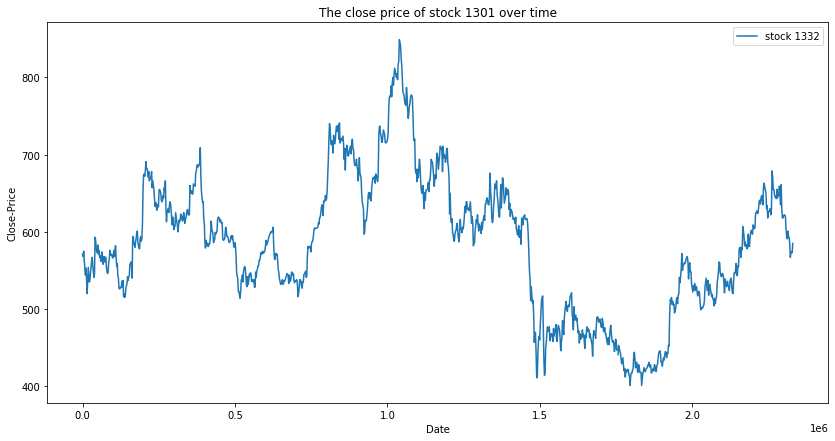

In [14]:
# 绘制单只股票的'High'价格的时间序列图
plt.figure(figsize=(14, 7))
plt.plot(single_stock['Close'],label='stock 1332')
plt.xlabel('Date')
plt.ylabel('Close-Price')
plt.title('The close price of stock 1301 over time')
plt.legend()
plt.show()

In [15]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(single_stock) * 0.67)
test_size = len(single_stock) - train_size
train, test = single_stock[:train_size], single_stock[train_size:]

In [16]:
train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1866,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,NaN,False,-0.022609
3731,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,NaN,False,-0.016014
5596,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,NaN,False,-0.016275
7461,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,NaN,False,0.016544


In [17]:
train.shape

(805, 12)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/01.png)

通过滑窗，我们得到的数据为——

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/16.png)

在时间序列中，一张二维表构成的训练特征 + 一个标签被称之为是“一个样本”，这个概念与我们在机器学习、甚至深度学习中习惯的“每行一个样本”的改变有所区别，因此在这里特别予以澄清。

在单变量数据集上，我们在唯一的列（也就是标签上）滑窗来构建数据集，但在多变量数据集上，我们有多种不同的滑窗方式——

- **特征滑窗**

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/02.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/03.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/04.png)

这样最终构建的数据集结构为(batch_size, 5, 5)，其中第一个5是window_size，也就代表一张表单中的time_step时间步步数，第二个5代表5个特征，两个数字都是5纯属巧合。在这种情况下，我们所得到的数据集为：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/17.png)

这种滑窗方式常见于**标签本身与时间的关系并不大**的情况。与气温、股价这种上个时间点明显会影响下一个时间点的标签不同，某些依据时间进行预测的标签之间并不存在特别强烈的关联。比如，一个用户在1月1日与1月2日的消费金额，我们很难说用户在1月1日有巨额消费，用户在1月2日就更倾向于有消费。有的用户可能因为第一天花光了所有的预算，因此第二天就不再消费，有的用户可能习惯性巨额消费，因此第二天还是巨额消费；有的用户可能没有两天都在购物，因此第二天没有出现消费。这种情况下，1月2日是否有消费其实并不与1月1日是否有消费强关联。

还有一些典型的例子，例如，一个网站的日访问量可能受多种因素影响，如营销活动、假日、特殊事件等，而不仅仅是前一天的访问量：

> 1月1日：网站因为发布了一篇热门文章而获得高访问量。

> 1月2日：尽管前一天访问量高，但没有新内容或特别活动，访问量可能大幅下降。

> 1月3日：网站可能因为一个相关话题突然在社交媒体上走红而意外获得巨大访问量，与前两天的访问量无明显直接关联。

在这种情况下，简单地依据前一天的访问量来预测下一天的访问量可能不太准确，需要考虑更多外部因素。

我们可以使用下面的函数来实现这样的滑窗——

In [18]:
train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1866,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,NaN,False,-0.022609
3731,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,NaN,False,-0.016014
5596,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,NaN,False,-0.016275
7461,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,NaN,False,0.016544


In [19]:
train.shape

(805, 12)

In [20]:
train = train.fillna(0)

In [21]:
import torch
import numpy as np

def create_multivariate_dataset(dataset, window_size):
    """
    将多变量时间序列转变为能够用于LSTM训练和预测的数据【特征法】
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 使用.values将Pandas DataFrame的切片转换为NumPy数组
        feature = dataset.iloc[i:i + window_size, 3:-1].values  # 转换为NumPy数组
        target = dataset.iloc[i + window_size - 1, -1]  # 目标值保持为标量即可
        X.append(feature)
        y.append(target)
    # 直接使用np.array转换列表为NumPy数组，并指定dtype确保数组类型正确
    return torch.FloatTensor(np.array(X, dtype=np.float32)), torch.FloatTensor(np.array(y, dtype=np.float32))

In [22]:
X_train, y_train = create_multivariate_dataset(train, 2)

In [23]:
X_train[:5]

tensor([[[5.6800e+02, 5.7600e+02, 5.6300e+02, 5.7100e+02, 2.7985e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.7200e+02, 5.7300e+02, 5.6500e+02, 5.6800e+02, 2.1629e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[5.7200e+02, 5.7300e+02, 5.6500e+02, 5.6800e+02, 2.1629e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.6700e+02, 5.7600e+02, 5.6300e+02, 5.7500e+02, 2.1256e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[5.6700e+02, 5.7600e+02, 5.6300e+02, 5.7500e+02, 2.1256e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.7300e+02, 5.7600e+02, 5.6100e+02, 5.6200e+02, 2.7446e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[5.7300e+02, 5.7600e+02, 5.6100e+02, 5.6200e+02, 2.7446e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.5900e+02, 5.6200e+02, 5.5100e+02, 5.5300e+02, 2.2318e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[5.5900e+02, 5.6200e+02, 5.5100e+02, 5.5300e+02

In [24]:
X_train.shape

torch.Size([803, 2, 8])

In [25]:
y_train[:10]

tensor([-0.0226, -0.0160, -0.0163,  0.0165, -0.0271, -0.0335,  0.0327,  0.0317,
        -0.0162, -0.0183])

- **带标签的滑窗**

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/05.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/06.png)

这种滑窗方式适应于除了特征之外，标签之间也随着时间互相影响的数据集。我们可以使用下面的函数来实现这样的滑窗——

In [26]:
import torch
import numpy as np

def create_multivariate_dataset_2(dataset, window_size):
    """
    将多变量时间序列转变为能够用于训练和预测的数据【带标签的滑窗】
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 选取从第4列到最后一列的特征和标签
        feature_and_label = dataset.iloc[i:i + window_size, 3:].values  # 包括标签在内的特征
        # 下一个时间点的标签作为目标
        target = dataset.iloc[i + window_size, -1]  # 使用下一个时间点的标签作为预测目标
        X.append(feature_and_label)
        y.append(target)
    return torch.FloatTensor(np.array(X, dtype=np.float32)), torch.FloatTensor(np.array(y, dtype=np.float32))

In [27]:
train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0.0,False,0.012324
1866,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,0.0,False,-0.022609
3731,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,0.0,False,-0.016014
5596,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,0.0,False,-0.016275
7461,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,0.0,False,0.016544


In [28]:
X_train_2, y_train_2 = create_multivariate_dataset_2(train, 2)

In [29]:
X_train_2.shape

torch.Size([803, 2, 9])

In [30]:
X_train.shape

torch.Size([803, 2, 8])

In [31]:
X_train_2[:5]

tensor([[[ 5.6800e+02,  5.7600e+02,  5.6300e+02,  5.7100e+02,  2.7985e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00,  1.2324e-02],
         [ 5.7200e+02,  5.7300e+02,  5.6500e+02,  5.6800e+02,  2.1629e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -2.2609e-02]],

        [[ 5.7200e+02,  5.7300e+02,  5.6500e+02,  5.6800e+02,  2.1629e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -2.2609e-02],
         [ 5.6700e+02,  5.7600e+02,  5.6300e+02,  5.7500e+02,  2.1256e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -1.6014e-02]],

        [[ 5.6700e+02,  5.7600e+02,  5.6300e+02,  5.7500e+02,  2.1256e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -1.6014e-02],
         [ 5.7300e+02,  5.7600e+02,  5.6100e+02,  5.6200e+02,  2.7446e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -1.6275e-02]],

        [[ 5.7300e+02,  5.7600e+02,  5.6100e+02,  5.6200e+02,  2.7446e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -1.6275e-02],
         [ 5.5900e+02,  5.62

In [32]:
y_train_2[:100]

tensor([-0.0160, -0.0163,  0.0165, -0.0271, -0.0335,  0.0327,  0.0317, -0.0162,
        -0.0183,  0.0075,  0.0148,  0.0128,  0.0162,  0.0071, -0.0194, -0.0144,
        -0.0128,  0.0092,  0.0861, -0.0067, -0.0170, -0.0086, -0.0017,  0.0175,
        -0.0206,  0.0088, -0.0156,  0.0035, -0.0123,  0.0000,  0.0214, -0.0087,
        -0.0193,  0.0072,  0.0107, -0.0123,  0.0107,  0.0000, -0.0229, -0.0108,
        -0.0036,  0.0037,  0.0237,  0.0071,  0.0195, -0.0104,  0.0018,  0.0000,
        -0.0053, -0.0035,  0.0071,  0.0105, -0.0139,  0.0158,  0.0087, -0.0275,
        -0.0194,  0.0072, -0.0286, -0.0055, -0.0241, -0.0019,  0.0019,  0.0019,
         0.0000,  0.0152, -0.0131,  0.0151, -0.0391,  0.0078, -0.0096,  0.0039,
         0.0193,  0.0057,  0.0057,  0.0169, -0.0092,  0.0093,  0.0018,  0.0276,
         0.0018,  0.0036, -0.0107, -0.0270,  0.1000, -0.0017, -0.0152,  0.0017,
        -0.0085,  0.0121,  0.0085,  0.0101,  0.0050, -0.0233, -0.0085, -0.0052,
        -0.0017,  0.0225,  0.0051, -0.01

相比只拥有特征的滑窗方式，携带标签的滑窗方式在很多场景下会给与算法更好的表现，这是因为——
> - **增加信息量**：通过将之前时间点的标签纳入到当前窗口的输入中，模型可以利用更多的上下文信息进行预测。这种方式可以提供更丰富的序列信息，可能有助于模型捕捉到更复杂的时间序列依赖关系。

> - **改善序列预测**：在某些情况下，特别是当连续的标签之间存在一定的序列相关性时，使用之前的标签作为额外的特征可以提高预测的准确性。

> - **增强模型的泛化能力**：通过学习如何将过去的标签和当前的特征结合起来进行预测，模型可能更好地理解序列数据的内在规律，从而在遇到新的、未见过的序列时表现得更好。

但是这种滑窗方式也会带来相应的问题——

> - **过拟合的风险**：更复杂的模型和更多的输入特征可能会增加过拟合的风险，尤其是在数据较少的情况下。需要适当的正则化策略和模型评估方法来避免这一问题。

> - **可能的数据泄露**：如果在预测时无法获取之前时间点的真实标签（例如，在实时预测或未来预测中），这种方法可能不适用。此外，如果不小心处理，使用未来数据（即“未来泄露”）可能会导致预测结果过于乐观。

> - **实施复杂性**：需要在数据预处理阶段更加小心地处理数据，确保每个窗口中包含正确的特征和标签，且在实际预测时能够符合模型的输入要求。

总的来说，这种滑窗方式可以为模型提供更多的上下文信息，可能有助于改善预测性能，但同时也带来了更高的模型复杂度和过拟合的风险。在实际应用中，是否采用这种方法应根据具体任务的需求、数据的可用性以及模型的性能进行权衡和决策。

- **特征标签共用的滑窗**

还有第三种信息更为全面的滑窗方式——

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/07.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/08.png)

In [33]:
import torch
import numpy as np

def create_multivariate_dataset_3(dataset, window_size):
    """
    将多变量时间序列转变为能够用于训练和预测的数据
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 选取从第4列到最后一列的特征和标签
        feature_and_label = dataset.iloc[i:i + window_size, 3:].copy().values  # 包括标签在内的特征
        # 下一个时间点的标签作为目标
        target = dataset.iloc[i + window_size - 1, -1]  # 使用窗口内最后一个时间点的标签作为预测目标
        # 将窗口内最后一个时间点的标签替换为-999
        feature_and_label[-1, -1] = -999
        X.append(feature_and_label)
        y.append(target)
    return torch.FloatTensor(np.array(X, dtype=np.float32)), torch.FloatTensor(np.array(y, dtype=np.float32))

In [34]:
train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0.0,False,0.012324
1866,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,0.0,False,-0.022609
3731,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,0.0,False,-0.016014
5596,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,0.0,False,-0.016275
7461,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,0.0,False,0.016544


In [35]:
X_train_3, y_train_3 = create_multivariate_dataset_3(train, 3)

In [36]:
X_train_3.shape

torch.Size([802, 3, 9])

In [37]:
X_train.shape

torch.Size([803, 2, 8])

In [56]:
X_train_3[0] #最后右下角的格子是-999

tensor([[ 5.6800e+02,  5.7600e+02,  5.6300e+02,  5.7100e+02,  2.7985e+06,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  1.2324e-02],
        [ 5.7200e+02,  5.7300e+02,  5.6500e+02,  5.6800e+02,  2.1629e+06,
          1.0000e+00,  0.0000e+00,  0.0000e+00, -2.2609e-02],
        [ 5.6700e+02,  5.7600e+02,  5.6300e+02,  5.7500e+02,  2.1256e+06,
          1.0000e+00,  0.0000e+00,  0.0000e+00, -9.9900e+02]])

In [39]:
y_train_3[:100]

tensor([-0.0160, -0.0163,  0.0165, -0.0271, -0.0335,  0.0327,  0.0317, -0.0162,
        -0.0183,  0.0075,  0.0148,  0.0128,  0.0162,  0.0071, -0.0194, -0.0144,
        -0.0128,  0.0092,  0.0861, -0.0067, -0.0170, -0.0086, -0.0017,  0.0175,
        -0.0206,  0.0088, -0.0156,  0.0035, -0.0123,  0.0000,  0.0214, -0.0087,
        -0.0193,  0.0072,  0.0107, -0.0123,  0.0107,  0.0000, -0.0229, -0.0108,
        -0.0036,  0.0037,  0.0237,  0.0071,  0.0195, -0.0104,  0.0018,  0.0000,
        -0.0053, -0.0035,  0.0071,  0.0105, -0.0139,  0.0158,  0.0087, -0.0275,
        -0.0194,  0.0072, -0.0286, -0.0055, -0.0241, -0.0019,  0.0019,  0.0019,
         0.0000,  0.0152, -0.0131,  0.0151, -0.0391,  0.0078, -0.0096,  0.0039,
         0.0193,  0.0057,  0.0057,  0.0169, -0.0092,  0.0093,  0.0018,  0.0276,
         0.0018,  0.0036, -0.0107, -0.0270,  0.1000, -0.0017, -0.0152,  0.0017,
        -0.0085,  0.0121,  0.0085,  0.0101,  0.0050, -0.0233, -0.0085, -0.0052,
        -0.0017,  0.0225,  0.0051, -0.01

这种滑窗方式尽可能携带了最多的信息，但并不是最为常见或常用的滑窗方式，这是因为——

- **特殊值的选择**：需要谨慎选择特殊值以避免与数据集中的实际值冲突。如果选取的特殊值与数据集中可能出现的值相近，可能会引入误导信息。

- **模型处理能力**：模型需要能够正确处理特殊值，不让这个值影响到模型的预测能力。这可能需要对模型进行特定的设计或预处理步骤，确保模型不会被特殊值误导。

#### 1.5.2.3 面板数据的重组流程

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/09.png)

In [40]:
df_stock_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [41]:
multi_stock = pd.concat([df_stock_prices[df_stock_prices['SecuritiesCode'] == 1332]
                         ,df_stock_prices[df_stock_prices['SecuritiesCode'] == 1301]
                         ,df_stock_prices[df_stock_prices['SecuritiesCode'] == 1376]
                        ])

In [42]:
multi_stock.shape

(3606, 12)

In [43]:
multi_stock.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1866,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,NaN,False,-0.022609
3731,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,NaN,False,-0.016014
5596,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,NaN,False,-0.016275
7461,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,NaN,False,0.016544


面板数据与多变量时间序列数据相比，有了更多需要考虑的因素。例如在LSTM与RNN的流程中，我们是沿着time_step，也是seq_length的方向进行扫描的。因此在这系列模型的假设中，我们认为LSTM和RNN建立的是每个保单内部的、行与行之间的联系，也就是时间步与时间步之间的联系。这隐含着一种暗示——即RNN和LSTM这类算法并不在意表单与表单之间的联系。**对于一个时间序列来说，相互影响的时序数据应该尽量在同一张表单上**。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/16.png)

- **忽略截面的滑窗**

这是最常见的、面板数据所使用的滑窗方式，我们使用这种滑窗方式的根本原因在于，它确实非常便捷！


![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/10.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/11.png)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/12.png)

我们可以使用下面的函数实现这种滑窗方式，这与多变量数据中、包含标签的滑窗方式一模一样——

In [44]:
import torch
import numpy as np

def create_multivariate_dataset_2(dataset, window_size):
    """
    将多变量时间序列转变为能够用于训练和预测的数据
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 选取从第4列到最后一列的特征和标签
        feature_and_label = dataset.iloc[i:i + window_size, 3:].values  # 包括标签在内的特征
        # 下一个时间点的标签作为目标
        target = dataset.iloc[i + window_size, -1]  # 使用下一个时间点的标签作为预测目标
        X.append(feature_and_label)
        y.append(target)
    return torch.FloatTensor(np.array(X, dtype=np.float32)), torch.FloatTensor(np.array(y, dtype=np.float32))

但是除此之外，我们还可以特地关注到截面的不同而避免跨截面的滑窗——

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/13.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/14.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/15.png)

这样的滑窗有多套不同的实现逻辑，我现在的实现逻辑如下。按多变量数据集的规律进行滑窗，但我要求每个窗内只能有唯一的Securities Code，如果一个数据集中出现了不同的Securities Code，则该窗会被删除。这种情况下，我们可以使用下面的函数来进行滑窗——

In [45]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(multi_stock) * 0.67)
test_size = len(multi_stock) - train_size
train, test = multi_stock[:train_size], multi_stock[train_size:]

In [46]:
import torch
import numpy as np

def create_multivariate_dataset_4(dataset, window_size):
    """
    将多变量时间序列转变为能够用于训练和预测的数据，确保每个窗口内的Securities Code唯一
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 检查窗口内的Securities Code是否唯一
        securities_code = dataset.iloc[i:i + window_size, 2]
        if len(securities_code.unique()) == 1:  # 如果Securities Code在窗口内唯一
            # 选取从第4列到最后一列的特征和标签
            feature_and_label = dataset.iloc[i:i + window_size, 3:].copy().values
            # 下一个时间点的标签作为目标
            target = dataset.iloc[i + window_size, -1]
            X.append(feature_and_label)
            y.append(target)
    return torch.FloatTensor(np.array(X, dtype=np.float32)), torch.FloatTensor(np.array(y, dtype=np.float32))

在这个版本的函数中，我们在添加窗口到X和y列表之前，首先检查窗口内所有行的Securities Code是否相同。这是通过选择窗口内的Securities Code列dataset.iloc[i:i + window_size, 2]，然后使用.unique()方法来检查其唯一值的数量。只有当len(securities_code.unique()) == 1时，即窗口内的Securities Code唯一时，我们才将该窗口的特征和标签添加到最终的数据集中。

In [49]:
train.shape

(2416, 12)

In [50]:
X_train_4, y_train_4= create_multivariate_dataset_4(train, 10)

In [52]:
X_train_4.shape #原则上来说应该有2416 - 10个窗，但是其中有多个窗涉及到跨越了截面（涉及到不同的股票，因此被删除了）

torch.Size([2388, 10, 9])

In [53]:
X_train.shape

torch.Size([803, 2, 8])

In [54]:
X_train_4[0]

tensor([[ 5.6800e+02,  5.7600e+02,  5.6300e+02,  5.7100e+02,  2.7985e+06,
          1.0000e+00,         nan,  0.0000e+00,  1.2324e-02],
        [ 5.7200e+02,  5.7300e+02,  5.6500e+02,  5.6800e+02,  2.1629e+06,
          1.0000e+00,         nan,  0.0000e+00, -2.2609e-02],
        [ 5.6700e+02,  5.7600e+02,  5.6300e+02,  5.7500e+02,  2.1256e+06,
          1.0000e+00,         nan,  0.0000e+00, -1.6014e-02],
        [ 5.7300e+02,  5.7600e+02,  5.6100e+02,  5.6200e+02,  2.7446e+06,
          1.0000e+00,         nan,  0.0000e+00, -1.6275e-02],
        [ 5.5900e+02,  5.6200e+02,  5.5100e+02,  5.5300e+02,  2.2318e+06,
          1.0000e+00,         nan,  0.0000e+00,  1.6544e-02],
        [ 5.5300e+02,  5.5600e+02,  5.4300e+02,  5.4400e+02,  2.5797e+06,
          1.0000e+00,         nan,  0.0000e+00, -2.7125e-02],
        [ 5.4300e+02,  5.5400e+02,  5.4100e+02,  5.5300e+02,  2.4857e+06,
          1.0000e+00,         nan,  0.0000e+00, -3.3457e-02],
        [ 5.4700e+02,  5.4900e+02,  5.3500e+02, 

In [55]:
y_train_4[:100]

tensor([-0.0183,  0.0075,  0.0148,  0.0128,  0.0162,  0.0071, -0.0194, -0.0144,
        -0.0128,  0.0092,  0.0861, -0.0067, -0.0170, -0.0086, -0.0017,  0.0175,
        -0.0206,  0.0088, -0.0156,  0.0035, -0.0123,  0.0000,  0.0214, -0.0087,
        -0.0193,  0.0072,  0.0107, -0.0123,  0.0107,  0.0000, -0.0229, -0.0108,
        -0.0036,  0.0037,  0.0237,  0.0071,  0.0195, -0.0104,  0.0018,  0.0000,
        -0.0053, -0.0035,  0.0071,  0.0105, -0.0139,  0.0158,  0.0087, -0.0275,
        -0.0194,  0.0072, -0.0286, -0.0055, -0.0241, -0.0019,  0.0019,  0.0019,
         0.0000,  0.0152, -0.0131,  0.0151, -0.0391,  0.0078, -0.0096,  0.0039,
         0.0193,  0.0057,  0.0057,  0.0169, -0.0092,  0.0093,  0.0018,  0.0276,
         0.0018,  0.0036, -0.0107, -0.0270,  0.1000, -0.0017, -0.0152,  0.0017,
        -0.0085,  0.0121,  0.0085,  0.0101,  0.0050, -0.0233, -0.0085, -0.0052,
        -0.0017,  0.0225,  0.0051, -0.0101,  0.0051,  0.0321,  0.0721,  0.0306,
         0.0015, -0.0044,  0.0089,  0.01

### 1.5.3 单步预测、多步预测与递归预测法

在之前的课程中我们了解了3类不同的时间序列数据、以及这些数据所涉及到的7-8类数据重组方式，相信你已经意识到、时间序列任务会比一般的机器学习/深度学习更复杂、更灵活、更有挑战性。尽管3种不同的时序数据已经让我们应接不暇，但事实上时序预测过程中难度更高的是预测方法本身。在过去的课程中，我们都是以最为经典的“点到序列”的预测方式给大家举例，但事实上，依据时间序列预测的不同细节，时序预测手段可以被分为以下四种——

> - **单步预测**：在每次预测时只预测序列的下一个时间点的值，也就是常见的“序列到点”（seq-2-point）的预测。

> - **多步预测**：在每次预测时预测序列接下来多个时间点的值，也就是之前提过的“序列到序列”（seq-2-seq）的预测。

> - **递归预测**：模型预测出下一个时间点或多个时间点的值后，将这些预测值作为输入的一部分来预测下一个时间点或多个时间点的值，如此递归下去。

> - **直接预测**：在预测过程中，模型只使用已存在的历史数据和历史标签作为输入，并不会将上一时刻预测出的结果作为下一时刻输入的一部分。

在这4种分类下，我们实际可以有单步递归预测、单步直接预测、多步递归预测和多步直接预测四种预测方法，之前我们所呈现的最经典的“序列到点”的预测就是单步直接预测法。本节就让我们一起来认识一下这4种预测方法。

- **从单步直接预测到多步直接预测**

从单步直接预测过渡到多步直接预测，是一个“牵一发而动全身”的策略，会涉及到一系列的改变和挑战，这些改变不仅会影响数据的预处理过程，例如**滑窗方式的调整**，还会影响到**模型的架构和训练过程**，如LSTM的输出方式和损失函数的计算。在多步预测中，滑窗方式可能需要根据预测范围进行优化，以确保每个窗口能够有效地捕获到对未来多个时间点预测所需的信息。同时，LSTM模型的输出层需要调整，以便能够一次性输出多个时间点的预测值，这可能要求模型学习和捕获更复杂的时间序列依赖关系。

此外，**损失函数的计算也变得更加复杂**，因为现在需要考虑模型对多个未来时间点预测的整体准确性。这可能会影响到模型的训练策略，包括早停机制的应用，因为早停判断现在需要基于多步预测的性能来进行。最后，从多步直接预测中提取最终预测值时，还需要考虑如何综合和处理模型输出的多个预测结果，以便得到对未来序列的最佳估计。这些问题共同构成了从单步直接预测到多步直接预测转变的复杂性，需要细致的方法和策略来有效地解决。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/18.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/19.png)

In [5]:
df_stock_prices = pd.read_csv('stock_prices.csv')

In [6]:
df_stock_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [7]:
df_stock_prices.shape

(2332531, 12)

In [8]:
df_stock_prices["SecuritiesCode"].unique().__len__() #一共包含2000支股票

2000

In [9]:
#提取其中一支股票的数据作为例子
# 选择单只股票的数据
single_stock = df_stock_prices[df_stock_prices['SecuritiesCode'] == 1332]

In [10]:
single_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1202 entries, 1 to 2330532
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowId             1202 non-null   object 
 1   Date              1202 non-null   object 
 2   SecuritiesCode    1202 non-null   int64  
 3   Open              1201 non-null   float64
 4   High              1201 non-null   float64
 5   Low               1201 non-null   float64
 6   Close             1201 non-null   float64
 7   Volume            1202 non-null   int64  
 8   AdjustmentFactor  1202 non-null   float64
 9   ExpectedDividend  10 non-null     float64
 10  SupervisionFlag   1202 non-null   bool   
 11  Target            1202 non-null   float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 113.9+ KB


> **完成简单预处理**

In [11]:
#我们修改预测目标，我们预测股价，而不预测原始竞赛中的Target（夏普比率）
single_stock = single_stock.copy()
#将Target名字修改为Sharpe Ratio
single_stock.rename(columns={'Target': 'Sharpe Ratio'}, inplace=True)
#将Close列取出
close_col = single_stock.pop('Close')
#将Close列添加到最后
single_stock.loc[:,'Close'] = close_col
#填补缺失值
single_stock.loc[:,"ExpectedDividend"] = single_stock.loc[:,"ExpectedDividend"].fillna(0)
single_stock.dropna(inplace=True)

In [12]:
#恢复索引
single_stock.index = range(single_stock.shape[0])

In [13]:
single_stock.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Sharpe Ratio,Close
0,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,2798500,1.0,0.0,False,0.012324,571.0
1,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,2162900,1.0,0.0,False,-0.022609,568.0
2,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,2125600,1.0,0.0,False,-0.016014,575.0
3,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,2744600,1.0,0.0,False,-0.016275,562.0
4,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,2231800,1.0,0.0,False,0.016544,553.0


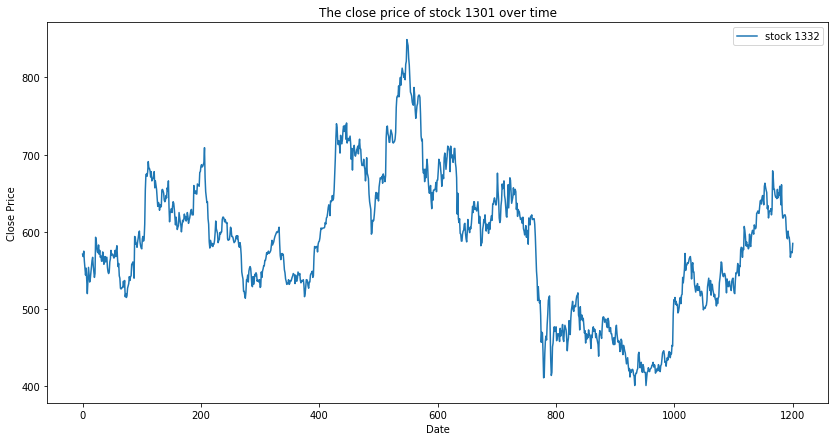

In [14]:
# 绘制单只股票的'High'价格的时间序列图
plt.figure(figsize=(14, 7))
plt.plot(single_stock['Close'],label='stock 1332')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('The close price of stock 1301 over time')
plt.legend()
plt.show()

> **数据分割与带标签的滑窗**

In [15]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(single_stock) * 0.67)
test_size = len(single_stock) - train_size
train, test = single_stock[:train_size], single_stock[train_size:]

In [24]:
import torch
import numpy as np

def create_multivariate_dataset_2(dataset, window_size, pred_len):
    """
    将多变量时间序列转变为能够用于训练和预测的数据【带标签的滑窗】
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
        pred_len：多步预测的预测范围/预测步长
    """
    X, y, y_indices = [], [], []
    for i in range(len(dataset) - window_size - pred_len + 1):
        # 选取从第4列到最后一列的特征和标签
        feature_and_label = dataset.iloc[i:i + window_size, 3:].values
        # 下一个时间点的标签作为目标
        target = dataset.iloc[(i + window_size):(i + window_size + pred_len), -1]
        # 记录本窗口中要预测的标签的时间点
        target_indices = list(range(i + window_size, i + window_size + pred_len))

        X.append(feature_and_label)
        y.append(target)
        #将每个标签的索引添加到y_indices列表中
        y_indices.extend(target_indices)
    
    X = torch.FloatTensor(np.array(X, dtype=np.float32))
    y = torch.FloatTensor(np.array(y, dtype=np.float32))
    
    return X, y, y_indices

In [25]:
window_size = 32
pred_len = 5

X_train_2, y_train_2, y_train_indices = create_multivariate_dataset_2(train, window_size, pred_len)
X_test_2, y_test_2, y_test_indices = create_multivariate_dataset_2(test, window_size, pred_len)

In [30]:
X_train_2.shape

torch.Size([768, 32, 9])

In [26]:
X_train_2[0] #取出的是索引为0-31的样本

tensor([[ 5.6800e+02,  5.7600e+02,  5.6300e+02,  2.7985e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  1.2324e-02,  5.7100e+02],
        [ 5.7200e+02,  5.7300e+02,  5.6500e+02,  2.1629e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00, -2.2609e-02,  5.6800e+02],
        [ 5.6700e+02,  5.7600e+02,  5.6300e+02,  2.1256e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00, -1.6014e-02,  5.7500e+02],
        [ 5.7300e+02,  5.7600e+02,  5.6100e+02,  2.7446e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00, -1.6275e-02,  5.6200e+02],
        [ 5.5900e+02,  5.6200e+02,  5.5100e+02,  2.2318e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  1.6544e-02,  5.5300e+02],
        [ 5.5300e+02,  5.5600e+02,  5.4300e+02,  2.5797e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00, -2.7125e-02,  5.4400e+02],
        [ 5.4300e+02,  5.5400e+02,  5.4100e+02,  2.4857e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00, -3.3457e-02,  5.5300e+02],
        [ 5.4700e+02,  5.4900e+02,  5.3500e+02, 

In [27]:
y_train_2[0] #32、33、34、35、36五个标签

tensor([562., 562., 574., 569., 558.])

In [29]:
y_train_indices[:10] #由于设置的pred_len是5，所以5个标签为一轮

[32, 33, 34, 35, 36, 33, 34, 35, 36, 37]

> **架构建立与参数设置**

In [31]:
#选择了最为简单的网络架构来进行实验
import torch.nn as nn
 
class MyLSTM(nn.Module):
    def __init__(self,input_dim, pred_len):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, pred_len)
    def forward(self, x):
        x, _ = self.lstm(x)
        #现在我要的是最后一个时间步，而不是全部时间步了
        x = self.linear(x[:,-1,:])
        return x

In [32]:
model = MyLSTM(input_dim = 9, pred_len = pred_len)

In [33]:
model(X_train_2).shape #针对全部的791窗口，都输出4个预测值

torch.Size([768, 5])

In [36]:
#设置GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [38]:
#设置参数
input_size = 1  #输入特征的维度
hidden_size = 50 #LSTM隐藏状态的维度
num_layers = 1 #LSTM层的数量
output_size = 1 #模型的输出维度
n_epochs = 2000 #迭代epoch
learning_rate = 0.001 #学习率

In [39]:
#实例化模型
model = MyLSTM(input_dim=9,pred_len = pred_len).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate) #定义优化器
loss_fn = nn.MSELoss() #定义损失函数
loader = data.DataLoader(data.TensorDataset(X_train_2, y_train_2)
                         #每个表单内部是保持时间顺序的即可，表单与表单之间可以shuffle
                         , shuffle=True
                         , batch_size=8) #将数据分批次

D:\ProgramData\Anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (4.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [40]:
for x,y in loader:
    print(x.shape)
    print(y)
    break

torch.Size([8, 32, 9])
tensor([[535., 544., 546., 547., 549.],
        [546., 547., 549., 541., 543.],
        [598., 600., 599., 600., 602.],
        [651., 643., 650., 650., 640.],
        [562., 551., 547., 539., 536.],
        [665., 673., 722., 736., 737.],
        [590., 596., 606., 604., 594.],
        [545., 543., 547., 545., 536.]])


> **实际训练流程**

In [41]:
# 初始化早停参数
early_stopping_patience = 3  # 设置容忍的epoch数，即在这么多epoch后如果没有改进就停止
early_stopping_counter = 0  # 用于跟踪没有改进的epoch数
best_train_rmse = float('inf')  # 初始化最佳的训练RMSE

In [42]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #验证与打印
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train_2.to(device)).cpu()
            train_rmse = np.sqrt(loss_fn(y_pred, y_train_2))
            y_pred = model(X_test_2.to(device)).cpu()
            test_rmse = np.sqrt(loss_fn(y_pred, y_test_2))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    
        # 早停检查
        if train_rmse < best_train_rmse:
            best_train_rmse = train_rmse
            early_stopping_counter = 0  # 重置计数器
        else:
            early_stopping_counter += 1  # 增加计数器
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered after epoch {epoch}. Training RMSE did not decrease for {early_stopping_patience} consecutive epochs.")
                break  # 跳出训练循环

Epoch 0: train RMSE 624.8842, test RMSE 518.7423
Epoch 100: train RMSE 514.5184, test RMSE 408.8167
Epoch 200: train RMSE 405.5827, test RMSE 300.8127
Epoch 300: train RMSE 298.6700, test RMSE 196.3940
Epoch 400: train RMSE 196.2972, test RMSE 104.2254
Epoch 500: train RMSE 108.4778, test RMSE 76.9970
Epoch 600: train RMSE 73.7087, test RMSE 122.7074
Epoch 700: train RMSE 73.3154, test RMSE 128.8437
Epoch 800: train RMSE 73.3153, test RMSE 128.9358
Epoch 900: train RMSE 73.3153, test RMSE 128.9346
Epoch 1000: train RMSE 73.3153, test RMSE 128.9217
Epoch 1100: train RMSE 73.3153, test RMSE 128.9151
Early stopping triggered after epoch 1100. Training RMSE did not decrease for 3 consecutive epochs.


> **输出预测值，绘制预测图像**

In [43]:
import pandas as pd

def get_predictions(model, X, y_indices):
    # 将模型移至CPU
    model.cpu()
    
    # 对输入数据X进行预测，调整形状，脱离计算图，并转换为numpy数组，然后移除单一维度
    y_pred = model(X).view(-1, 1).detach().numpy().squeeze()
    
    # 创建一个DataFrame，包含时间步和对应的预测值
    result = pd.DataFrame(zip(y_indices, y_pred), columns=["time_step", "prediction"])
    
    # 按时间步分组，并计算每个时间步的预测值的平均值，以处理重复预测的情况
    result = result.groupby(by="time_step").mean()
    print(result.shape)
    
    return result

In [45]:
#get_predictions函数代码解析

In [46]:
model.cpu()
y_pred_train = model(X_train_2).view(-1, 1).detach().numpy().squeeze()
y_pred_test = model(X_test_2).view(-1, 1).detach().numpy().squeeze()

In [47]:
y_pred_train

array([622.04004, 621.93176, 621.79816, ..., 621.79816, 621.6527 ,
       621.5235 ], dtype=float32)

In [48]:
y_pred_train.shape

(3840,)

In [49]:
y_train_indices.__len__()

3840

In [50]:
train_result = pd.DataFrame(zip(y_train_indices,y_pred_train),columns = ["time_step","prediction"])

In [51]:
train_result.head()

,time_step,prediction
0,32,622.040039
1,33,621.931763
2,34,621.798157
3,35,621.652710
4,36,621.523499


In [52]:
train["Close"]

0      571.0
1      568.0
2      575.0
3      562.0
4      553.0
       ...  
799    472.0
800    477.0
801    459.0
802    464.0
803    468.0
Name: Close, Length: 804, dtype: float64

In [53]:
train_result.groupby(by="time_step").mean()

,prediction
time_step,
32,622.040039
33,621.985901
34,621.923340
35,621.855652
36,621.789246
...,...
799,621.789246
800,621.726562
801,621.658142


In [55]:
train_result = get_predictions(model,X_train_2,y_train_indices)
test_result = get_predictions(model,X_test_2,y_test_indices)

(772, 1)
(365, 1)


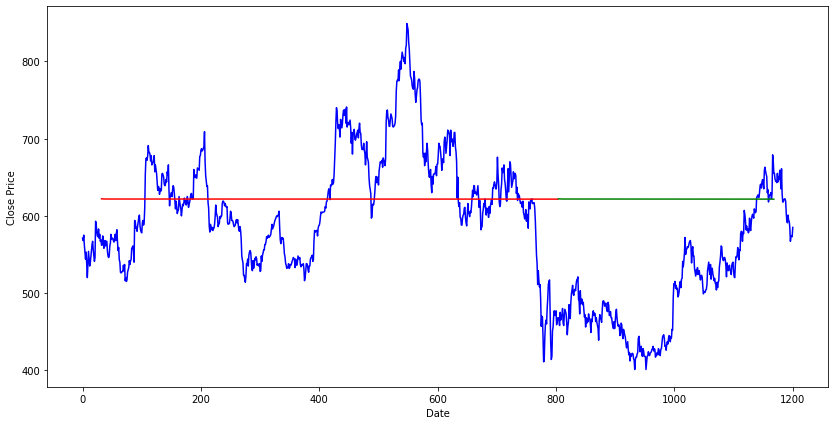

In [57]:
with torch.no_grad():
    plt.figure(figsize=(14, 7))
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    # 绘制训练集上的损失的图像
    train_plot = np.ones_like(single_stock.index) * np.nan
    train_plot[window_size:train_size] = train_result.loc[:,"prediction"]
    # 绘制测试集上的损失的图像
    test_plot = np.ones_like(single_stock.index) * np.nan
    test_plot[train_size:(train_size + test_size - window_size)] = test_result.loc[:,"prediction"]
plt.plot(single_stock.loc[:,"Close"], c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

- **从多步预测到递归多步预测**

从多步直接预测转向多步递归预测时，会遇到一系列挑战和考量，这些不仅涉及模型架构的调整，还包括数据处理、预测策略和性能评估等多个方面的变化。在多步递归预测中，模型不再一次性输出所有未来时间点的预测值，而是逐步使用前一步的预测结果作为下一步预测的输入。这种预测方式带来了以下挑战：

**预测依赖性增加**：由于每一步的预测都依赖于前一步的输出，错误可能会在预测过程中逐步累积，导致长期预测的准确性降低。这种依赖性要求模型具有很高的短期预测准确性，以减少误差传播。

**滑窗策略的调整**：在多步递归预测中，滑窗的策略需要灵活调整，以适应逐步生成预测值的需要。每次预测后，新的预测值需要被整合到后续窗口的输入中，这可能要求动态调整窗口的内容。

**损失函数和训练过程的复杂性**：在递归预测中，损失函数的计算可能需要在每一步预测后即时进行，以便及时调整模型参数。这种即时反馈机制增加了训练过程的复杂性，并可能需要特别设计的训练循环。

**早停机制的适应性**：传统的早停机制可能需要针对递归预测进行调整，因为模型性能的评估现在涉及到连续多步的预测结果。确定何时停止训练以避免过拟合，可能需要考虑递归预测的特殊性质和误差累积的影响。

**最终预测值的确定性问题**：在多步递归预测中，由于每一步预测都是基于先前的预测结果，因此如何从一系列递归生成的预测中确定最终的预测值可能会更加复杂。可能需要采取额外的策略，比如使用多种模型的预测结果进行综合，以提高预测的可靠性。

**实时数据的整合问题**：在实际应用中，如果有新的实时数据可用，将这些数据有效地整合到递归预测过程中，以及如何平衡模型对新数据和自身预测结果的依赖，是另一个需要考虑的挑战。

总的来说，从多步直接预测到多步递归预测的转变，虽然为模型提供了更大的灵活性和适应性，但也带来了一系列挑战，需要通过精心的模型设计和训练策略来克服。

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

# 假设 single_stock 是原始的 DataFrame，包含 130 行和 6 列，其中最后一列是标签
single_stock = pd.DataFrame(np.random.rand(130, 6), columns=[f'Feature_{i}' for i in range(1, 6)] + ['Label'])

class MyLSTM(nn.Module):
    def __init__(self, input_dim, pred_len):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, pred_len)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])  # 使用最后一个时间步
        return x

def train_lstm_with_dynamic_window(single_stock, window_size=10, pred_len=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_dim = single_stock.shape[1] - 1  # 减去1是因为最后一列是标签
    model = MyLSTM(input_dim=input_dim, pred_len=pred_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 将 DataFrame 转换为张量
    data_tensor = torch.tensor(single_stock.values, dtype=torch.float32)

    for start_idx in range(0, len(single_stock) - window_size - pred_len + 1):
        # 分割出当前窗口的数据
        current_window = data_tensor[start_idx:start_idx + window_size].unsqueeze(0).to(device)  # 增加批次维度
        # 目标标签为窗口之后的 pred_len 个标签
        target = data_tensor[start_idx + window_size:start_idx + window_size + pred_len, -1].unsqueeze(0).to(device)

        # 预测
        model.train()
        optimizer.zero_grad()
        output = model(current_window)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # 使用预测结果更新原始数据中对应的标签
        data_tensor[start_idx + window_size:start_idx + window_size + pred_len, -1] = output.detach().squeeze()

    # 返回更新后的数据
    return data_tensor

【后续待补充，递归预测的完整代码~】

### 1.5.4 LSTM在股价数据集上的预测实战

In [4]:
import numpy as np #数据处理
import pandas as pd #数据处理
import matplotlib as mlp
import matplotlib.pyplot as plt #绘图
from sklearn.preprocessing import MinMaxScaler #·数据预处理
from sklearn.metrics import mean_squared_error
import torch 
import torch.nn as nn #导入pytorch中的基本类
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data
# typing 模块提供了一些类型，辅助函数中的参数类型定义
from typing import Union,List,Tuple,Iterable
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from decimal import ROUND_HALF_UP, Decimal

In [5]:
torch.__version__

'2.2.0+cu121'

In [139]:
stock= pd.read_csv('stock_prices.csv')
stock_list = pd.read_csv('stock_list.csv') 

In [140]:
stock.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [143]:
stock.isnull().sum()

RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64

In [8]:
# 定义为数据进行预处理的函数
def preprocess(data):
    '''
    对训练集数据进行处理：
        将日期转换为datetime格式；
        使用0来填充ExpectedDividend和Target中的缺失值；
        将SupervisionFlag从布尔型转换为整数型；
        填充Open、High、Low和Close列中的缺失值；
    '''
    # 将日期从字符串格式转换为datetime格式
    # data['Date'] = pd.to_datetime(data['Date'])
    
    # 将 Date 列转换为 datetime 格式
    # 因为我们在前面查看数据类型的时候发现Date为object类型
    data.loc[: ,"Date"] = pd.to_datetime(data.loc[: ,"Date"], format="%Y-%m-%d")
    
    # 使用0来填充ExpectedDividend和Target中的缺失值
    # 因为我们这个函数可能会同时在不同的特征工程下被调用
    # 比如测试集就没有Target，所以使用try-except 语句避免报错
    try: 
        data['ExpectedDividend'] = data['ExpectedDividend'].fillna(0)
    except:
        pass
    try:
        data['Target'] = data['Target'].fillna(0)
    except:
        pass
    
    # 将SupervisionFlag从布尔型转换为整数型（True转为1，False转为0）
    data["SupervisionFlag"] = data["SupervisionFlag"].astype(int)
    
    # 填充Open、High、Low和Close列中的缺失值
    cols = ['Open', 'High', 'Low', 'Close']
    data.loc[:,cols] = data.loc[:,cols].ffill().bfill()
    
    # 删除不需要的列RowId
    data = data.drop(['RowId'], axis=1)
    return data

In [9]:
def timeseries_feature(timeseries):
    """:params timeseris: 必须是时间戳格式才能调用dt方法"""
    timeseries = pd.to_datetime(timeseries, format="%Y-%m-%d")
    features_new = pd.DataFrame([])
    cols_name = timeseries.name

    # 提取年份、月份和日期
    features_new[cols_name + '_year'] = timeseries.dt.year
    features_new[cols_name + '_month'] = timeseries.dt.month
    features_new[cols_name + '_day'] = timeseries.dt.day

    # 提取自然周期
    features_new[cols_name + '_quarter'] = timeseries.dt.quarter
    features_new[cols_name + '_weekofyear'] = timeseries.dt.isocalendar()["week"]
    features_new[cols_name + '_dayofweek'] = timeseries.dt.dayofweek
    # features_new[cols_name + '_weekend'] = (features_new[cols_name + '_dayofweek'] >= 5).astype(int)

    return features_new

In [10]:
def create_feature(df_temp:pd.DataFrame
                   ,periods:Union[List,Tuple,Iterable])->pd.DataFrame:
    """
    :param df_temp: pd.DataFrame, 输入的数据框，其中需要包含金融时间序列数据。
                    数据框需要至少包含日期、股票代码、收盘价、调整收盘价、最高价、最低价等列。
                    其中日期会被用于排序，股票代码用于分组操作，而其他列用于特征工程。

    :param periods: Union[List, Tuple, Iterable], 一个可迭代的对象（如列表、元组等），包含了想要用于计算历史数据平移和窗口统计的时间段。
                    例如，如果想要考虑过去5天、10天和20天的数据，那么periods就应该是[5, 10, 20]。

    :return: pd.DataFrame, 增加了新特征的数据框。
    """
    df = df_temp.copy()
    df.sort_values(by='Date',inplace=True)
    key_col = 'SecuritiesCode'

    # 历史平移
    for period in periods:
        df.loc[:,f'history_close_{period}']=df.groupby(key_col)['Close'].shift(period)

        #窗口统计
        for stat in ['mean', 'std', 'max', 'min', 'median']:
            df.loc[:,f'window_close_{period}_{stat}'] = df.groupby(key_col)['AdjustedClose'].rolling(window=period).agg(stat).values

        # max-min feature
        df.loc[:,f'window_close_{period}_max-min'] = df[f'window_close_{period}_max']-df[f'window_close_{period}_min'].values
        
        # 波动率
        avg_value = (df[f'window_close_{period}_max'] + df[f'window_close_{period}_min']) / 2
        df.loc[:,f'window_close_{period}_fluctuation_rate'] = df[f'window_close_{period}_max-min'] / avg_value
        
        #增长率特征
        df.loc[:,f'window_close{period}_pctchange'] = df.groupby(key_col)['AdjustedClose'].pct_change(period).values

        # diff 特征
        df.loc[:,f'window_close{period}_diff'] = df.groupby(key_col)['AdjustedClose'].diff(period).values
        df.loc[:,f"Volatility_{period}Day"] = np.log(df['AdjustedClose']).groupby(df[key_col]).diff().rolling(period).std()

        # 扩张窗口特征
        df.loc[:,f"ExpMovingAvg_{period}Day"] = df.groupby(key_col)['AdjustedClose'].ewm(span=period,adjust=False).mean().values  
    
    # 尝试使用times参数，衰减因子只能选择halflife，这里我们设置为5D(天)【5天为一周】
    # 发现效果并不好
#     times = pd.to_datetime(df['Date'])
#     df.loc[:,"ExpMovingAvg_{}Day".format(period)] = df.groupby(key_col)['AdjustedClose'].ewm(times=times,halflife='5D').mean().values

    df.loc[:,f'expand_mean'] = df.groupby(key_col)['Close'].expanding().mean().values
    
    df['Upper_Shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    df['Lower_Shadow'] = df[['Close', 'Open']].min(axis=1) - df['Low']
    
    # 基础时间特征
    time_feature = timeseries_feature(df['Date'])
    return pd.concat((df,time_feature),axis=1)

In [11]:
# 定义baseline中使用的adjust_price函数
def adjust_price(price):
    """
    参数：
    price (pd.DataFrame) : 包含股票价格信息的 pd.DataFrame。

    返回：
    price DataFrame (pd.DataFrame): 含有新生成的 AdjustedClose 的股票价格DataFrame

    函数功能：
    该函数将输入的原始股价数据进行处理，生成带有调整后收盘价(AdjustedClose)的新DataFrame。
    AdjustedClose的计算方式为原收盘价与调整因子(AdjustmentFactor)的累计乘积，结果保留一位小数。
    若计算后的AdjustedClose为0，则替换为空值(np.nan)，并对此列数据进行向前填充，以保持数据完整性。
    """
    # 将 Date 列转换为 datetime 格式
    # 因为我们在前面查看数据类型的时候发现Date为object类型
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        参数:
            df (pd.DataFrame)  : 单个 SecuritiesCode 的股票价格
        返回:
            df (pd.DataFrame) : 单个 SecuritiesCode 的带有 AdjustedClose 的股票价格
        """
        # 排序数据以生成 CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # 生成 CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()#累乘
        # 生成 AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # 反转顺序
        df = df.sort_values("Date")
        # 填充 AdjustedClose，将 0 替换为 np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # 向前填充 AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df
    
    # 生成 AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    return price

In [12]:
# 预处理股票数据集
stock = preprocess(stock)
# 行业可能会对股票有影响，所以将行业也加入特征进行建模
# 将17SectorName进行labelencoder
stock_list['17SectorName'] = LabelEncoder().fit_transform(stock_list['17SectorName'])
# 并入主表
price = stock.merge(stock_list[['SecuritiesCode','17SectorName']],on='SecuritiesCode')
# 尝试删除股息建模
price.drop(columns='ExpectedDividend',inplace=True)

In [13]:
# 调整股价
price = adjust_price(price)

In [14]:
new_feature = create_feature(price,periods=[5,10,20,30,40,50,60,70])

C:\Users\Shuyu\AppData\Local\Temp/ipykernel_8120/2580554070.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:,f'expand_mean'] = df.groupby(key_col)['Close'].expanding().mean().values
C:\Users\Shuyu\AppData\Local\Temp/ipykernel_8120/2580554070.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Upper_Shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
C:\Users\Shuyu\AppData\Local\Temp/ipykernel_8120/2580554070.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [15]:
new_feature.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target,...,ExpMovingAvg_70Day,expand_mean,Upper_Shadow,Lower_Shadow,Date_year,Date_month,Date_day,Date_quarter,Date_weekofyear,Date_dayofweek
0,2017-01-04 00:00:00,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0,0.000730,...,2742.000000,2742.0,13.0,4.0,2017,1,4,1,1,2
1861349,2017-01-04 00:00:00,8185,2800.0,2847.0,2785.0,2846.0,57500,1.0,0,0.015827,...,2741.887324,2740.0,1.0,15.0,2017,1,4,1,1,2
285188,2017-01-04 00:00:00,2698,1770.0,1783.0,1764.0,1778.0,45700,1.0,0,0.005062,...,2741.834160,2740.0,5.0,6.0,2017,1,4,1,1,2
1860147,2017-01-04 00:00:00,8182,1482.0,1512.0,1482.0,1510.0,50700,1.0,0,0.000649,...,2742.007846,2742.0,2.0,0.0,2017,1,4,1,1,2
286390,2017-01-04 00:00:00,2702,3090.0,3090.0,3050.0,3060.0,384900,1.0,0,0.000000,...,2742.092132,2742.6,0.0,10.0,2017,1,4,1,1,2


In [152]:
new_feature = new_feature.dropna()

In [153]:
new_feature.shape

(2055125, 118)

In [239]:
single_stock = new_feature[new_feature['SecuritiesCode'] == 8185]

single_stock = single_stock.drop(columns=['Date','SecuritiesCode'],axis=1)
single_stock.rename(columns={'Target': 'Sharpe Ratio'}, inplace=True)
#将Close列取出
close_col = single_stock.pop('Close')
#将Close列添加到最后
single_stock.loc[:,'Close'] = close_col

In [240]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(single_stock) * 0.67)
test_size = len(single_stock) - train_size
train, test = single_stock[:train_size], single_stock[train_size:]

In [241]:
#scaler = MinMaxScaler()
#scaler.fit(train)

In [242]:
#train_ = pd.DataFrame(scaler.transform(train), columns = train.columns)
#test_ = pd.DataFrame(scaler.transform(test), columns = train.columns)

In [243]:
#train_.shape

In [244]:
#train_.head() #已经将编号、时间等信息去除

In [245]:
import torch
import numpy as np

def create_multivariate_dataset_2(dataset, window_size, pred_len):
    """
    将多变量时间序列转变为能够用于训练和预测的数据【带标签的滑窗】
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
        pred_len：多步预测的预测范围/预测步长
    """
    X, y, y_indices = [], [], []
    for i in range(len(dataset) - window_size - pred_len + 1):
        # 选取全部列的特征和标签，这是基于最前面的几列无效信息已经被去除了
        feature_and_label = dataset.iloc[i:i + window_size, :].values
        # 下一个时间点的标签作为目标
        target = dataset.iloc[(i + window_size):(i + window_size + pred_len), -1]
        # 记录本窗口中要预测的标签的时间点
        target_indices = list(range(i + window_size, i + window_size + pred_len))

        X.append(feature_and_label)
        y.append(target)
        #将每个标签的索引添加到y_indices列表中
        y_indices.extend(target_indices)
    
    X = torch.FloatTensor(np.array(X, dtype=np.float32))
    y = torch.FloatTensor(np.array(y, dtype=np.float32))
    
    return X, y, y_indices

In [246]:
window_size = 32
pred_len = 5

X_train_2, y_train_2, y_train_indices = create_multivariate_dataset_2(train, window_size, pred_len)
X_test_2, y_test_2, y_test_indices = create_multivariate_dataset_2(test, window_size, pred_len)

In [247]:
X_train_2.shape

torch.Size([670, 32, 116])

In [248]:
X_train_2[0]

tensor([[2.6670e+03, 2.6700e+03, 2.6140e+03,  ..., 1.5000e+01, 4.0000e+00,
         2.6290e+03],
        [2.6420e+03, 2.7160e+03, 2.6420e+03,  ..., 1.6000e+01, 0.0000e+00,
         2.7150e+03],
        [2.7150e+03, 2.7450e+03, 2.7030e+03,  ..., 1.6000e+01, 1.0000e+00,
         2.7320e+03],
        ...,
        [2.8060e+03, 2.8100e+03, 2.7780e+03,  ..., 2.2000e+01, 1.0000e+00,
         2.7930e+03],
        [2.8050e+03, 2.8190e+03, 2.7750e+03,  ..., 2.2000e+01, 2.0000e+00,
         2.7760e+03],
        [2.7700e+03, 2.8410e+03, 2.7700e+03,  ..., 2.2000e+01, 3.0000e+00,
         2.8300e+03]])

In [249]:
y_train_2.shape

torch.Size([670, 5])

In [250]:
y_train_indices[:10]

[32, 33, 34, 35, 36, 33, 34, 35, 36, 37]

> **架构建立与参数设置**

In [251]:
#选择了最为简单的网络架构来进行实验
import torch.nn as nn
 
class MyLSTM(nn.Module):
    def __init__(self,input_dim, pred_len):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=128, num_layers=5, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=5, batch_first=True)
        self.linear1 = nn.Linear(256, 128)
        self.linear2 = nn.Linear(128, pred_len)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        #现在我要的是最后一个时间步，而不是全部时间步了
        x = self.linear2(self.linear1(x[:,-1,:]))
        return x

In [252]:
model = MyLSTM(input_dim = 116, pred_len = 5)

In [253]:
#设置GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [254]:
#设置参数
input_size = 1  #输入特征的维度
hidden_size = 50 #LSTM隐藏状态的维度
num_layers = 1 #LSTM层的数量
output_size = 1 #模型的输出维度
n_epochs = 2000 #迭代epoch
learning_rate = 0.001 #学习率

In [255]:
#实例化模型
model = MyLSTM(input_dim=X_train_2.shape[2],pred_len = pred_len).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate) #定义优化器
loss_fn = nn.MSELoss() #定义损失函数
loader = data.DataLoader(data.TensorDataset(X_train_2, y_train_2)
                         #每个表单内部是保持时间顺序的即可，表单与表单之间可以shuffle
                         , shuffle=False
                         , batch_size=8) #将数据分批次

In [256]:
for x,y in loader:
    print(x.shape)
    print(y)
    break

torch.Size([8, 32, 116])
tensor([[2856., 2908., 2889., 2884., 2846.],
        [2908., 2889., 2884., 2846., 2824.],
        [2889., 2884., 2846., 2824., 2816.],
        [2884., 2846., 2824., 2816., 2835.],
        [2846., 2824., 2816., 2835., 2841.],
        [2824., 2816., 2835., 2841., 2888.],
        [2816., 2835., 2841., 2888., 2900.],
        [2835., 2841., 2888., 2900., 2942.]])


> **实际训练流程**

In [257]:
# 初始化早停参数
early_stopping_patience = 3  # 设置容忍的epoch数，即在这么多epoch后如果没有改进就停止
early_stopping_counter = 0  # 用于跟踪没有改进的epoch数
best_train_rmse = float('inf')  # 初始化最佳的训练RMSE

In [258]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #验证与打印
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train_2.to(device)).cpu()
            train_rmse = np.sqrt(loss_fn(y_pred, y_train_2))
            y_pred = model(X_test_2.to(device)).cpu()
            test_rmse = np.sqrt(loss_fn(y_pred, y_test_2))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    
        # 早停检查
        if train_rmse - best_train_rmse < best_train_rmse*0.02:
            best_train_rmse = train_rmse
            early_stopping_counter = 0  # 重置计数器
        else:
            early_stopping_counter += 1  # 增加计数器
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered after epoch {epoch}. Training RMSE did not decrease for {early_stopping_patience} consecutive epochs.")
                break  # 跳出训练循环

Epoch 0: train RMSE 1843.7595, test RMSE 553.3846
Epoch 100: train RMSE 635.3111, test RMSE 965.2829
Epoch 200: train RMSE 635.2489, test RMSE 965.4487
Epoch 300: train RMSE 635.1774, test RMSE 965.6394
Epoch 400: train RMSE 635.0049, test RMSE 966.0997
Epoch 500: train RMSE 634.5250, test RMSE 967.3853
Epoch 600: train RMSE 633.1440, test RMSE 971.1194
Epoch 700: train RMSE 628.3307, test RMSE 984.5690
Epoch 800: train RMSE 615.7813, test RMSE 1023.7033
Epoch 900: train RMSE 608.5953, test RMSE 1050.1417
Epoch 1000: train RMSE 605.2706, test RMSE 1063.9502
Epoch 1100: train RMSE 602.4156, test RMSE 1076.9470
Epoch 1200: train RMSE 600.7659, test RMSE 1085.0804
Epoch 1300: train RMSE 599.9965, test RMSE 1089.0662
Epoch 1400: train RMSE 599.4521, test RMSE 1091.9688


KeyboardInterrupt: 

> **输出预测值，绘制预测图像**

In [259]:
import pandas as pd

def get_predictions(model, X, y_indices):
    # 将模型移至CPU
    model.cpu()
    
    # 对输入数据X进行预测，调整形状，脱离计算图，并转换为numpy数组，然后移除单一维度
    y_pred = model(X).view(-1, 1).detach().numpy().squeeze()
    
    # 创建一个DataFrame，包含时间步和对应的预测值
    result = pd.DataFrame(zip(y_indices, y_pred), columns=["time_step", "prediction"])
    
    # 按时间步分组，并计算每个时间步的预测值的平均值，以处理重复预测的情况
    result = result.groupby(by="time_step").mean()
    print(result.shape)
    
    return result

In [260]:
train_result = get_predictions(model,X_train_2,y_train_indices)
test_result = get_predictions(model,X_test_2,y_test_indices)

(674, 1)
(316, 1)


In [263]:
single_stock.index = range(single_stock.shape[0])

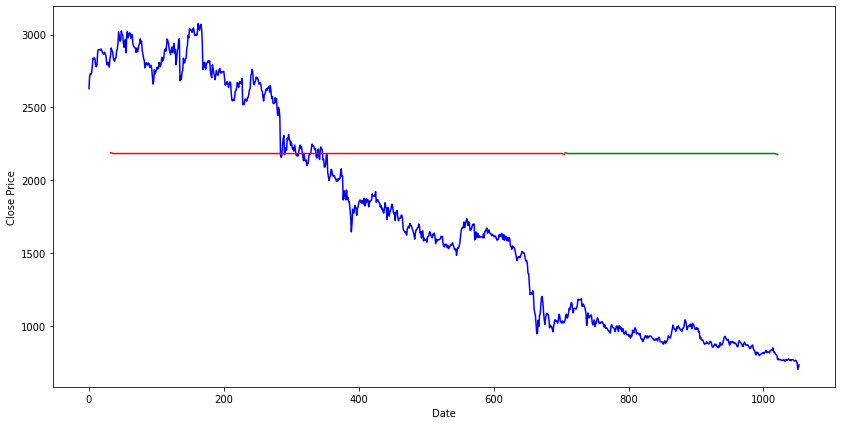

In [264]:
with torch.no_grad():
    plt.figure(figsize=(14, 7))
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    # 绘制训练集上的损失的图像
    train_plot = np.ones_like(single_stock.index) * np.nan
    train_plot[window_size:train_size] = train_result.loc[:,"prediction"]
    # 绘制测试集上的损失的图像
    test_plot = np.ones_like(single_stock.index) * np.nan
    test_plot[train_size:(train_size + test_size - window_size)] = test_result.loc[:,"prediction"]
plt.plot(single_stock.loc[:,"Close"], c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()